# 016 change in resolution for concatenations
* including also hypervariable regions only


-> advice from draf writing discussion: change names to 16S23S5S; change contig to xxxITSxxx; change v1v2etc to 16Sv1etc. maybe remove UPGMA; keep only silhouettescore

-> iqtree -s o.fas -wbtl -bb  --> o.fas.uboot will have ultrafast bootsrap trees w blens

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Bio import Seq, SeqIO, Align, AlignIO, Phylo, Alphabet, pairwise2 
from Bio.SeqRecord import SeqRecord
from Bio.Align import AlignInfo, Applications
from Bio.Phylo import draw, TreeConstruction  #TreeConstruction.DistanceCalculator, TreeConstruction.DistanceTreeConstructor 
# https://bioinformatics.stackexchange.com/questions/4337/biopython-phylogenetic-tree-replace-branch-tip-labels-by-sequence-logos

import numpy as np
import seaborn as sns
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import skbio, parasail, dendropy, pandas
import sys, gzip, re, glob, pickle, collections, subprocess, os, errno, random, itertools

def print_redblack(textr, textb=""):
    print ('\x1b[0;1;31;1m'+ str(textr) + '\x1b[0;1;30;1m'+ str(textb) + '\x1b[0m')

In [2]:
##  "Mycobacterium" is not truely positive or negative
gram_positive = ["Clostridium", "Enterococcus", "Listeria", "Mycobacterium", "Staphylococcus", "Streptococcus"]
gram_negative = ["Campylobacter", "Escherichia", "Helicobacter", "Leptospira", 
                 "Neisseria", "Pseudomonas", "Salmonella"]
outdir = "./016_results/"

rrna_types = ["16S", "23S", "5S"]; hyper_types = ["16Sv1v2", "16Sv4"]
iupac_dna = {''.join(sorted(v)):k for k,v in Seq.IUPAC.IUPACData.ambiguous_dna_values.items()}
hypervar = np.array([135, 360, 540, 820, 900, 1100, 1240, 1390, 1500]) # last position, including assumed 16S size
hypervar = hypervar/hypervar[-1] # fractions, w.r.t sequence length
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0076185 for V1V2

In [3]:
def return_species_name_from_table (table_fs):
    return str(table_fs[3]) + "_" + str(re.search('GCF_(\d+)\.', table_fs[1]).group(1))

def subsample_accept (sp_name, collection_counter):
    x = collection_counter[sp_name]
    if x < 3:
        return False
    if x > 50:
        return np.random.random() < 100/x
    return True

In [4]:
## read species names translation tables and keep only genus+species 
table_filenames_species = []
for bact in gram_negative[1:]: ## exclude Campy
    file_name = glob.glob("/media/deolivl/QIB_deolivl/bigdata/" + bact + "*/names.txt")[0]
    file_lines = [line.strip() for line in open(file_name, 'r')]
    thistbl = [line.split('\t') for line in file_lines[1:]] # concatenation of lists
    fnames = glob.glob("/media/deolivl/QIB_deolivl/bigdata/" + bact + "*/GCF_*.gbff.gz")
    ## alterantive 1: use map index
    idx=[i for j in thistbl for i,fname in enumerate(fnames) if j[0] in fname]
    thistbl = [[fnames[idx[i]]] + j for i,j in enumerate(thistbl)]
    ## alternative 2: use bash wildcard
    #thistbl = [glob.glob("/media/deolivl/QIB_deolivl/bigdata/" + bact + "*/*"+x[0]+"*.gbff.gz")+x for x in thistbl]
    table_filenames_species += thistbl

table_filenames_species = [line + ["_".join(line[2].split()[:2]).split('.')[0]] for line in table_filenames_species]
table_filenames_species = [line + [line[2].split()[0]] for line in table_filenames_species]  
print_redblack ("table_filenames_species[] has:"," filename,  GCF_id, full species_subsp name, species name (genus+sp), genus\n")

print (table_filenames_species[230], "\n", set([x[4] for x  in table_filenames_species]))

species_counter = collections.Counter([x[3] for x in table_filenames_species if x[3][-3:] !="_sp"])
print_redblack ("distinct species: ", species_counter)

tbl_fl_sp = [x  for x in table_filenames_species if subsample_accept (x[3], species_counter)]
tmp_counter = collections.Counter([x[3] for x in tbl_fl_sp])
print_redblack(tmp_counter, " length :: " + str(len(tbl_fl_sp)))
random.shuffle(tbl_fl_sp)

table_filenames_species[] has: filename,  GCF_id, full species_subsp name, species name (genus+sp), genus

['/media/deolivl/QIB_deolivl/bigdata/Escherichia/GCF_001900515.1_ASM190051v1_genomic.gbff.gz', 'GCF_001900515.1', 'Escherichia coli', 'Escherichia_coli', 'Escherichia'] 
 {'Neisseria', 'Neisseriaceae', 'Leptospira', 'Helicobacter', 'Escherichia', 'Pseudomonas', 'Salmonella'}
distinct species: Counter({'Escherichia_coli': 701, 'Salmonella_enterica': 562, 'Pseudomonas_aeruginosa': 171, 'Helicobacter_pylori': 124, 'Neisseria_meningitidis': 94, 'Pseudomonas_chlororaphis': 42, 'Pseudomonas_syringae': 29, 'Pseudomonas_putida': 28, 'Neisseria_gonorrhoeae': 27, 'Pseudomonas_fluorescens': 21, 'Pseudomonas_stutzeri': 17, 'Escherichia_albertii': 14, 'Leptospira_interrogans': 9, 'Pseudomonas_protegens': 6, 'Helicobacter_cinaedi': 6, 'Leptospira_borgpetersenii': 6, 'Pseudomonas_mendocina': 6, 'Pseudomonas_synxantha': 6, 'Pseudomonas_orientalis': 5, 'Pseudomonas_monteilii': 5, 'Pseudomonas_bras

In [4]:
def get_hypervar_16S (sequence):
    size = len(sequence)
    n1 = int(hypervar[2] * size); n2 = int(hypervar[3] * size); n3 = int(hypervar[1] * size) #v4, v1+v2
    return {"16Sv4":sequence[n1:n2], "16Sv1v2":sequence[:n3]}
    
def align_seqs_small (unaligned):
    """ muscle alignment using pipes (not files) """
    cline = Align.Applications.MuscleCommandline(clwstrict=False, fasta=True, diags=True, maxiters=2, maxhours=4.) 
    child = subprocess.Popen(str(cline), stdin=subprocess.PIPE, stderr=subprocess.PIPE, stdout=subprocess.PIPE, 
                             universal_newlines=True, shell=(sys.platform!="win32"))

    SeqIO.write(unaligned, child.stdin, "fasta") # after this muscle is still waiting, so...
    child.stdin.close() # ... we must close the handle by hand, which will then make muscle start calculations
    aligned = AlignIO.read(child.stdout, "fasta")  # read from stdout as a fasta file 
    child.terminate()
    return aligned

def align_seqs (sequences=None, maxiters=12, infile=None, outfile=None, mafft = True):
    print ("started aligning...", flush=True, end=" ")
    if (sequences is None) and (infile is None):
        print ("ERROR: You must give me an alignment object or file")
        return [] ## OTOH if both are present then infile is overwritten with contents of sequences[]
    if infile is None:
        ifl = "/tmp/in.fas"
    else:
        ifl = infile
    if outfile is None:
        ofl = "/tmp/out.fas"
    else:
        ofl = outfile
    SeqIO.write(sequences, ifl, "fasta")
    if (mafft is False):
        proc_run = subprocess.check_output("muscle -in " + ifl + " -diags -maxiters " + str(maxiters) + " -out " + ofl,
                                       shell=True, universal_newlines=True)
    else: # "--parttree --6merpair" and 0.123 is to avoid very long alignments
        proc_run = subprocess.check_output("mafft --ep 0.3 --op 3.0 --auto " + ifl + " > " + ofl,
                                       shell=True, universal_newlines=True)
      
    aligned = AlignIO.read(ofl, "fasta")
    print ("Finished",flush=True)
    if infile is None:
        os.system("rm -f " + ifl)
    if outfile is None:
        os.system("rm -f " + ofl)
    return aligned

def ambiguous_consensus_from_alignment (align):
    #summary_align = AlignInfo.SummaryInfo(Align.MultipleSeqAlignment(align))
    summary_align = AlignInfo.SummaryInfo(align) # must be aligned sequences
    pssm = summary_align.pos_specific_score_matrix()
    consensus = []; 
    for score in pssm: # something like {'A': 0, 'T': 4.0, 'G': 0, 'C': 2.0} for each column
        base_present = ''.join(sorted([base for base in "ACGT" if score[base] > 0])) ## neglect indels
        if (base_present): 
            consensus.append(iupac_dna[base_present])
    return ''.join(consensus)

def get_longest_from_dict(rRNA):
    longest_dict = {}
    for rna in rrna_types:
        longest_dict[rna] = str(rRNA[rna][ np.argsort([len(x) for x in rRNA[rna]])[0] ].seq)
    return longest_dict

def get_consensus_from_dict(rRNA):
    consensus_dict = {}
    for rna in rrna_types:
        consensus_dict[rna] = ambiguous_consensus_from_alignment(align_seqs_small(rRNA[rna]))
    return consensus_dict

### chose random set of samples, get longest copy as well as _all_ copies

In [6]:
def get_rrna_from_genbank_to_dict (table_fs):
    gbank = SeqIO.parse(gzip.open(table_fs[0], "rt"), "genbank")
    rRNA = {}
    for rna in rrna_types:
        rRNA[rna] = []
    genome = next(gbank) # no point in iterating over gbank, only this has whole information
    for feature in genome.features:
        if(feature.type == "rRNA"):
            for rna in rrna_types:
                if rna in feature.qualifiers['product'][0]:
                    this_product = rna
                    desc = feature.qualifiers['locus_tag'][0]
                    seq = feature.extract(genome.seq)
                    record = SeqRecord(seq, id=desc)
                    rRNA[this_product].append(record)
                    break
    success = True
    for rna in rrna_types:
        success = success and rRNA[rna]
    if success:
        return rRNA
    return None

In [7]:
## run this if you want to reset variables
rna_concat = {}
rna_consen = {}
stats_dict = {}
for rna in rrna_types+hyper_types: # must also initalise 'v4' and 'v4v6'
    rna_concat[rna] = []
    rna_consen[rna] = []
for rna in rrna_types:
    stats_dict["Longest " + rna] = []
    stats_dict["Consensus " + rna] = []
    stats_dict["Copies " + rna] = []

In [8]:
all_fl_sp = []

for file_counter, tfs in enumerate(tbl_fl_sp):
    if not (file_counter+1)%20:
        print (str(file_counter+1), end=" ", flush=True)
    rna_dict = get_rrna_from_genbank_to_dict (tfs)
    # (some list will have no usable features or b/c too long/too short; some dict has no usable features
    if rna_dict:
        spname = return_species_name_from_table (tfs)
        
        concat_seqs = get_longest_from_dict (rna_dict)
        concat_seqs.update(get_hypervar_16S(concat_seqs['16S'])) # adds two elements, with v4 and v1v2 regions
        for rna, rseq in concat_seqs.items():
            rna_concat[rna].append(SeqRecord(Seq.Seq(rseq,Alphabet.IUPAC.ambiguous_dna),id=spname,description=spname))
        
        consen_seqs = get_consensus_from_dict (rna_dict)
        consen_seqs.update(get_hypervar_16S(consen_seqs['16S'])) # adds two elements, with v4 and v1v2 regions
        for rna, rseq in consen_seqs.items():
            rna_consen[rna].append(SeqRecord(Seq.Seq(rseq,Alphabet.IUPAC.ambiguous_dna),id=spname,description=spname))
        
        for rna in rrna_types: # stored into CSV 
            stats_dict["Longest " + rna].append(len(concat_seqs[rna]))
            stats_dict["Consensus " + rna].append(len(consen_seqs[rna]))
            stats_dict["Copies " + rna].append(len(rna_dict[rna])) # how many copies
        all_fl_sp.append(tfs)    

# save table
fl=gzip.open(outdir+"all_fl_sp.pickle.gz", "w"); pickle.dump([all_fl_sp],fl,2); fl.close()

for rna in rrna_types:
    x = stats_dict["Longest " + rna]
    print_redblack (rna); print (np.mean(x), np.std(x), len(x), " | ", 
           np.min(x), np.percentile(x, 5), np.percentile(x, 95), np.max(x))
    x = stats_dict["Consensus " + rna]
    print_redblack ("consensus"); print (np.mean(x), np.std(x), len(x), " | ", 
           np.min(x), np.percentile(x, 5), np.percentile(x, 95), np.max(x))

20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 16S
1538.58970976 31.8369734058 758  |  1075 1509.0 1556.0 1556
consensus
1542.09762533 15.5056707528 758  |  1501 1509.0 1556.0 1582
23S
2912.32585752 89.1915648572 758  |  2070 2888.0 2967.0 3632
consensus
2940.31398417 112.199450611 758  |  2832 2889.0 3109.0 5180
5S
115.941952507 1.4688704356 758  |  91 114.0 118.0 120
consensus
117.100263852 30.6773656806 758  |  91 114.0 118.0 960


In [ ]:
## DO NOT RUN : reading from previous analysis
#fl=gzip.open(outdir +  "all_fl_sp.pickle.gz", "r"); all_fl_sp = pickle.load(fl); fl.close()

In [10]:
def create_dataframe_from_table_filename_species (table_fs, stats_dictionary):
    dfd = {"Organism":[], "Accession Number":[],"File Name":[], "Species":[]}
    for elem in table_fs:
        dfd["Accession Number"].append(elem[1])
        dfd["Organism"].append(elem[2])
        dfd["File Name"].append(elem[0].split("/")[-1])
        dfd["Species"].append(" ".join(elem[3].split("_")))
    for k,v in stats_dictionary.items(): ## append statistics 
        dfd[k] = v
    return pandas.DataFrame(data=dfd)

df = create_dataframe_from_table_filename_species (all_fl_sp, stats_dict)
df.to_csv(outdir + "all.csv")

In [11]:
# align each of the dictionary values (lists of unaligned seqs)
concat_aligned = {k:align_seqs(sequences=v, outfile=outdir + k + "_long.fasta") for k,v in rna_concat.items()}
consen_aligned = {k:align_seqs(sequences=v, outfile=outdir + k + "_consensus.fasta") for k,v in rna_consen.items()}

started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished
started aligning... Finished


In [5]:
## rna_alignment is a dict with one alignment per rRNA; below the dictionaries have _sequence_ids_ as keys.
def add_missing_sequences (align_1, align_2):
    seqdict_1 = SeqIO.to_dict(align_1); seqdict_2 = SeqIO.to_dict(align_2)
    n1 = align_1.get_alignment_length(); n2 = align_2.get_alignment_length();
    for k in seqdict_1:
        if k not in seqdict_2:
            seqdict_2[k] = SeqRecord(Seq.Seq('N'*n2, Alphabet.IUPAC.ambiguous_dna), id=k, description=k)
    for k in seqdict_2:
        if k not in seqdict_1:
            seqdict_1[k] = SeqRecord(Seq.Seq('N'*n1, Alphabet.IUPAC.ambiguous_dna), id=k, description=k)
    return Align.MultipleSeqAlignment(seqdict_1.values()), Align.MultipleSeqAlignment(seqdict_2.values())

def create_species_genus_labels (seqlist, have_paralogs = False): 
    species = ['_'.join(sequence.id.split('_')[:2]) for sequence in seqlist]
    genus = [sequence.id.split('_')[0] for sequence in seqlist]
    if have_paralogs:# assumes 'genus_species_code_number' names 
        sample = ['_'.join(sequence.id.split('_')[:3]) for sequence in seqlist]
        return species, genus, sample
    return species, genus 

### if resuming from previous analysis, run code below to read genome names table and alignments

In [6]:
# DO NOT RUN::  read table
concat_aligned = {k:AlignIO.read(outdir + k + "_long.fasta", "fasta") for k in rrna_types+hyper_types}
consen_aligned = {k:AlignIO.read(outdir + k + "_consensus.fasta", "fasta") for k in rrna_types+hyper_types}

In [7]:
outfile_list = [outdir + str(keys) for keys in hyper_types + rrna_types] # 16S etc. but also v4 v4v6
print (outfile_list)

['./016_results/16Sv1v2', './016_results/16Sv4', './016_results/16S', './016_results/23S', './016_results/5S']


In [8]:
# order of outfile_list is important, since defines order in table, figures

## (1) Individual rRNAs (already done by align_seqs)

for r1, r2 in itertools.combinations(rrna_types,2): # ensure all samples are present
    concat_aligned[r1], concat_aligned[r2] = add_missing_sequences(concat_aligned[r1], concat_aligned[r2])
    
## (2) pairs of rRNAs (16+23, 16+5, 23+5)
for r1, r2 in itertools.combinations(rrna_types,2):
    outfile_list.append(outdir + str(r1) + str(r2))
    for thisalign, suff in zip([concat_aligned, consen_aligned], ["_long", "_consensus"]):
        seq_dict_1 = SeqIO.to_dict(thisalign[r1])
        seq_dict_2 = SeqIO.to_dict(thisalign[r2])
        tmpalign = [SeqRecord(Seq.Seq(str(seq_dict_1[k].seq) + str(seq_dict_2[k].seq), 
                                      Alphabet.IUPAC.ambiguous_dna), id=k, description=k) for k in seq_dict_1]
        # tmpalign has concat seqs related to _same_ sample (that's why a dictionary and not simply align1+align2)
        output_handle = open (outdir + str(r1) + str(r2) + suff + ".fasta", "w")
        SeqIO.write(tmpalign, output_handle, "fasta")
        output_handle.close()

## (3) all three concatenated
r1, r2, r3 = rrna_types
outfile_list.append(outdir + str(r1) + str(r2) + str(r3))

for thisalign, suff in zip([concat_aligned, consen_aligned], ["_long", "_consensus"]):
    seq_dict_1 = SeqIO.to_dict(thisalign[r1])
    seq_dict_2 = SeqIO.to_dict(thisalign[r2])
    seq_dict_3 = SeqIO.to_dict(thisalign[r3])
    tmpalign = [SeqRecord(Seq.Seq(str(seq_dict_1[k].seq) + str(seq_dict_2[k].seq) + str(seq_dict_3[k].seq), 
                                  Alphabet.IUPAC.ambiguous_dna), id=k, description=k) for k in seq_dict_1]
    output_handle = open (outdir + str(r1) + str(r2) + str(r3) + suff + ".fasta", "w")
    SeqIO.write(tmpalign, output_handle, "fasta")
    output_handle.close()

In [11]:
#for fname in [ofile + suff for suff in ["_long", "_consensus"] for ofile in outfile_list]:
for fname in [ofile + suff for suff in ["_consensus"] for ofile in outfile_list]:
    subprocess.check_output("iqtree-omp -s " + fname + ".fasta -nt 8 -m HKY+G",shell=True,universal_newlines=True)

KeyboardInterrupt: 

In [9]:
def patristic_distances_from_treefile (filename, have_paralogs = False, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if shuffle:
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 1000)
    species = ['_'.join(t.label.split('_')[:2]) for t in tree.taxon_namespace] ## follow order of taxon_namespace
    genus = [t.label.split('_')[0] for t in tree.taxon_namespace]
    ntaxa = len(tree.taxon_namespace)
    distmat = np.zeros((ntaxa,ntaxa)) # diagonals are zero
    nodemat = np.zeros((ntaxa,ntaxa))
    pdm = tree.phylogenetic_distance_matrix() # initialises class
    for i,j in itertools.combinations(range(ntaxa),2):
        distmat[i,j] = distmat[j,i] = pdm.distance(tree.taxon_namespace[i], tree.taxon_namespace[j])
        nodemat[i,j] = nodemat[j,i] = pdm.path_edge_count(tree.taxon_namespace[i], tree.taxon_namespace[j])
    if have_paralogs:
        sample = ['_'.join(t.label.split('_')[:3]) for t in tree.taxon_namespace]
        return species, genus, distmat, nodemat, sample
    return species, genus, distmat, nodemat

In [10]:
def silhouette_str(dist, labels):
    distrib = metrics.silhouette_samples(dist, labels, metric="precomputed")
    return '{:7.3f}'.format(np.percentile(distrib, 5)) + \
    '{:7.3f}'.format(np.percentile(distrib, 25)) + \
    '{:7.3f}  '.format(sum(distrib>0)/float(len(distrib))) 

Each triplet from `silhouette_str()` has $5\%$, $25\%$ and proportion of positive silhouettes. And we have two triplets on the left for _species_ (S), and two on the right for _genera_ (G), one being from weighted (W) and one from unweighted (U) patristic distances. Therefore the header is: SW SU GW GU

By the way having low silhouettte scores is not necessarily bad, since
1. clusters of size one will have score of _zero_ **by definition** (should be _one_ given the silhouette function but this would lead to ever-increasing clusterings)
2. clusters with within-distance zero are perfect, while for phylogenies we want non-zero diversification
3. they can be negative if for a case like `((A:a,A:a,A:a),B:b)` with $a>b$ since $d(A,A)=2a > a+b = d(A,B)$ --- however the taxonomic classification is fine for A and B

In [29]:
sp, ge, mat, mat2 = patristic_distances_from_treefile (outfile_list[0]+ "_long.fasta.treefile", shuffle = True)
x = metrics.silhouette_samples(mat2, sp, metric="precomputed") ## unweighted (path difference) patristic
# bar plot uses path difference
bplot_label = ["random"] ; bplot_hue = ["silhouette"]; bplot_value = [sum(x>0)/float(len(x))]
x = metrics.silhouette_samples(mat, sp, metric="precomputed") ## weighted patristic distance
# violin plots use weighted distances
rnatypesilu = ["random"] * x.shape[0];  silulist_sp = list(x)

print ('     {:12s}'.format("random"), "\t", silhouette_str(mat, sp),  silhouette_str(mat2, sp), 
        silhouette_str(mat, ge), silhouette_str(mat2, ge))

suffix1 = ".fasta.treefile"
title1  = "ML    "
for suffix2, title2 in zip (["_long", "_consensus"], ["long ", "cons "]):
    suffix = suffix2 + suffix1; title = title2 + title1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        sp, ge, mat, mat2 = patristic_distances_from_treefile (fname + suffix)
        print (title + '{:6s}'.format(rname), "\t", silhouette_str(mat, sp),  silhouette_str(mat2, sp), 
            silhouette_str(mat, ge), silhouette_str(mat2, ge))
        if "long" in title:
            x = metrics.silhouette_samples(mat, sp, metric="precomputed") ## weighted patristic distance
            bplot_label.append(rname) ; bplot_hue.append("silhouette"); bplot_value.append(sum(x>0)/float(len(x)))
            # x = metrics.silhouette_samples(mat2, sp, metric="precomputed") ## unweighted
            rnatypesilu.extend([str(rname)+"\n" + title] * x.shape[0])
            silulist_sp.extend(list(x))
        

     random       	  -0.890 -0.827  0.016    -0.376 -0.283  0.008    -0.243 -0.206  0.150    -0.060 -0.035  0.099  
long ML    16Sv1v2 	  -0.746  0.160  0.786    -0.495 -0.265  0.483    -0.034  0.135  0.949    -0.326 -0.066  0.673  
long ML    16Sv4  	  -0.589  0.753  0.917    -0.651 -0.328  0.459     0.123  0.249  0.968    -0.399 -0.085  0.704  
long ML    16S    	  -0.363  0.552  0.920    -0.474 -0.154  0.598     0.622  0.799  1.000    -0.353 -0.036  0.687  
long ML    23S    	  -0.064  0.531  0.945    -0.459 -0.138  0.662     0.503  0.726  1.000    -0.196  0.112  0.877  
long ML    5S     	  -1.000 -1.000  0.547    -0.755 -0.430  0.441     0.206  0.790  0.967    -0.622 -0.386  0.489  
long ML    16S23S 	  -0.092  0.519  0.949    -0.492 -0.013  0.748     0.607  0.748  1.000    -0.220  0.082  0.873  
long ML    16S5S  	  -0.234  0.492  0.920    -0.529 -0.226  0.596     0.633  0.791  1.000    -0.458 -0.032  0.727  
long ML    23S5S  	  -0.172  0.508  0.941    -0.458 -0.093  0.665     0

In [30]:
def sp_count_from_list (labels):
    x = ['_'.join(t.split('_')[:2]) for t in labels]
    return len(set(x))

def genera_count_from_list (labels):
    x = [t.split('_')[0] for t in labels]
    return len(set(x))

def bipartitions_from_treefile (filename, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if shuffle:
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 1000)
    tree.encode_bipartitions()
    # bits[i] have the list of labels associated to bipartition (edge) i
    bits = [[x.label for x in tree.taxon_namespace.bitmask_taxa_list(i.leafset_bitmask)] for i in tree.bipartition_encoding]
    sp_count = [sp_count_from_list(i) for i in bits if len(i) > 1]
    genera_count = [genera_count_from_list(i) for i in bits if len(i) > 1]
    return sp_count, genera_count

def bipart_str(counts):
    distrib = np.array(counts)
    return '{:7.3f}'.format(np.mean(distrib)) + \
    '{:7.3f}'.format(np.percentile(distrib, 90)) + \
    '{:7.3f}\t'.format(sum(distrib == 1)/float(len(distrib))) 

sp0, ge0 = bipartitions_from_treefile (outfile_list[0]+ "_long.fasta.treefile", shuffle = True)
print ('{:7s}'.format("random"), "\t", bipart_str(sp0), bipart_str(ge0))
rnatypelist = ["random"] * len(sp0)
monolist_sp = [x/max(sp0) for x in sp0]; monolist_ge = [x/max(ge0) for x in ge0]
bplot_label.append("random") ; bplot_hue.append("monophyly"); bplot_value.append(sum(np.array(sp0) == 1)/float(len(sp0)))

suffix1 = ".fasta.treefile"
title1  = "ML    "
for suffix2, title2 in zip (["_long", "_consensus"], ["long ", "cons "]):
    suffix = suffix2 + suffix1; title = title2 + title1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        sp, ge = bipartitions_from_treefile (fname + suffix)
        print (title + '{:7s}'.format(rname), "\t", bipart_str(sp), bipart_str(ge))        
        if "long" in title:
            rnatypelist.extend([str(rname)+"\n" + title] * len(sp))
            bplot_label.append(rname) ; bplot_hue.append("monophyly"); bplot_value.append(sum(np.array(sp) == 1)/float(len(sp)))
            monolist_sp.extend([x/max(sp) for x in sp]); monolist_ge.extend([x/max(ge0) for x in ge])

random  	   4.758 10.000  0.029	   3.042  5.000  0.102	
long ML    16Sv1v2 	   1.987  2.000  0.770	   1.163  1.000  0.948	
long ML    16Sv4   	   2.545  2.000  0.774	   1.274  1.000  0.938	
long ML    16S     	   1.757  2.000  0.839	   1.130  1.000  0.971	
long ML    23S     	   1.591  2.000  0.862	   1.103  1.000  0.976	
long ML    5S      	   3.569  6.000  0.419	   1.362  2.000  0.839	
long ML    16S23S  	   1.433  2.000  0.862	   1.057  1.000  0.985	
long ML    16S5S   	   1.671  2.000  0.862	   1.110  1.000  0.975	
long ML    23S5S   	   1.519  2.000  0.866	   1.070  1.000  0.983	
long ML    16S23S5S 	   1.507  2.000  0.851	   1.070  1.000  0.983	
cons ML    16Sv1v2 	   2.316  4.000  0.716	   1.247  2.000  0.880	
cons ML    16Sv4   	   2.302  2.000  0.737	   1.255  1.000  0.946	
cons ML    16S     	   2.095  2.000  0.840	   1.216  1.000  0.954	
cons ML    23S     	   1.598  2.000  0.898	   1.107  1.000  0.972	
cons ML    5S      	   2.742  4.000  0.444	   1.216  2.000  0.893	
cons 

Text(0.5, 1.0, 'proportion of sample pairs with good silhouettes and of monophyletic nodes,both under ML (higher is better)')

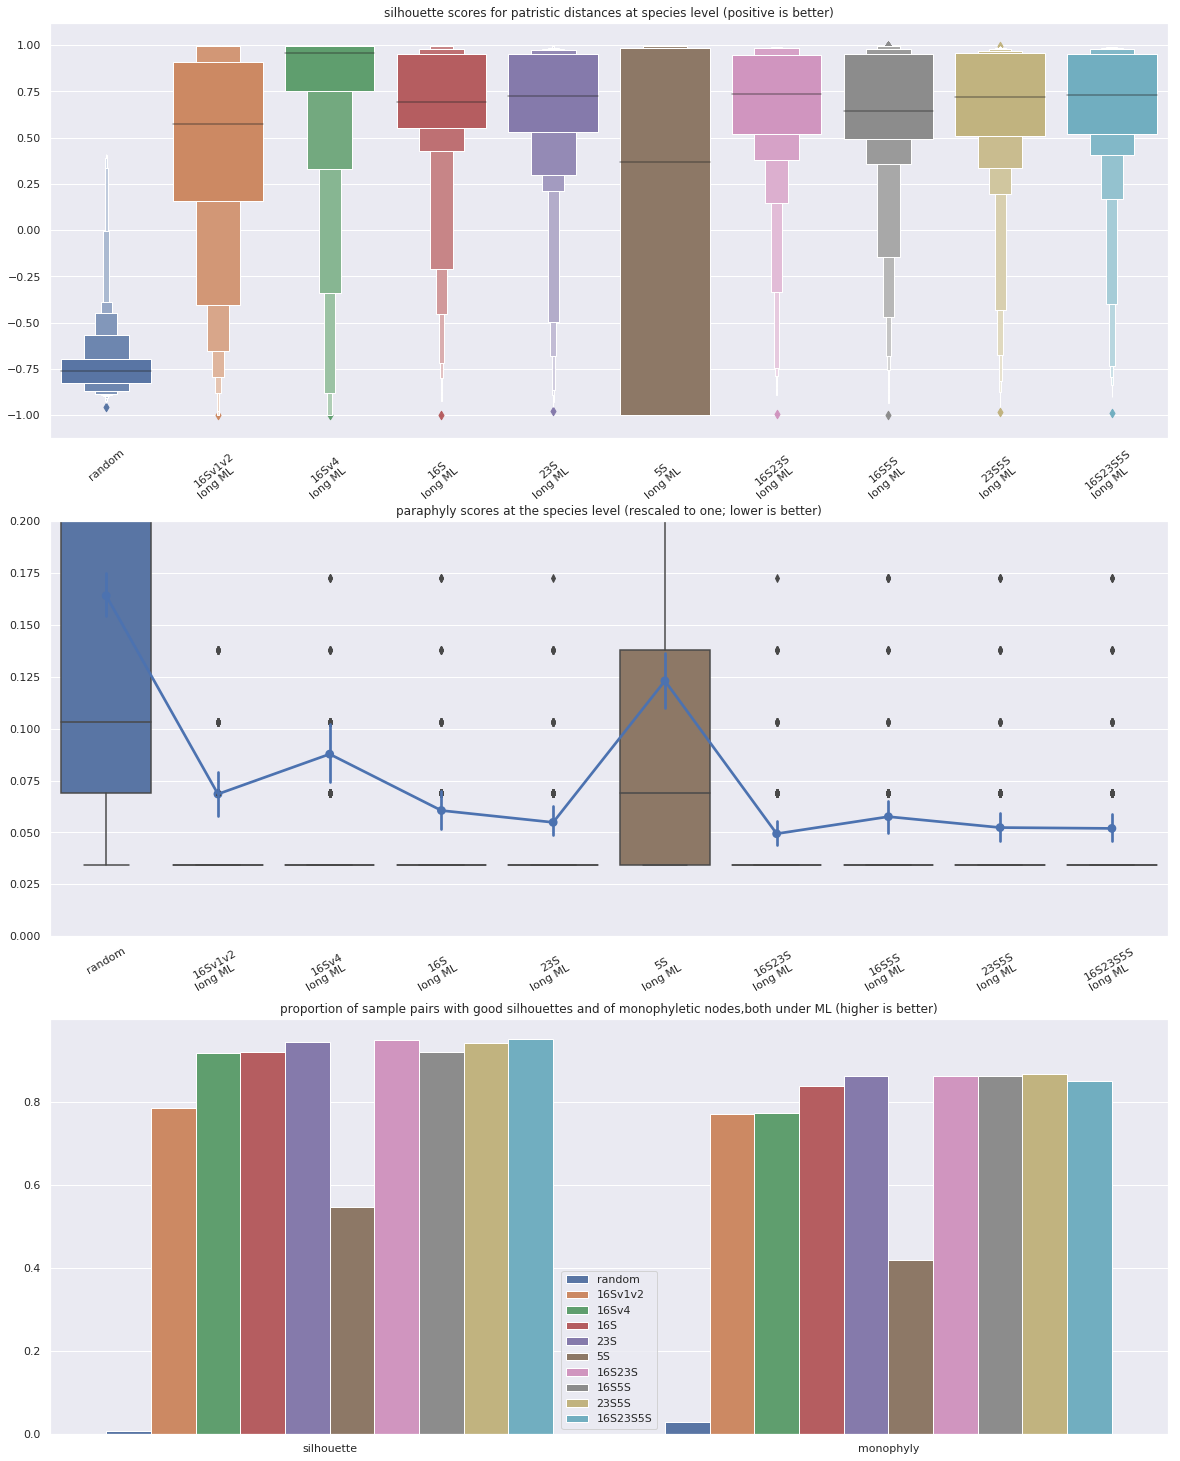

In [31]:
fig, axes = plt.subplots(3,1) ; fig.set_size_inches(16, 20)
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set()

sns.boxenplot(x=rnatypesilu, y=silulist_sp, ax = axes[0])
#sns.pointplot(x=rnatypesilu, y=silulist_sp, ax = axes[0])
axes[0].set_title("silhouette scores for patristic distances at species level (positive is better)")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=40)

sns.boxplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  # inner="sticks",
sns.pointplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  
axes[1].set_ylim(0,0.2)
axes[1].set_title("paraphyly scores at the species level (rescaled to one; lower is better)")
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=30)

sns.barplot(hue=bplot_label, y=bplot_value, x=bplot_hue, ax=axes[2])
axes[2].set_title("proportion of sample pairs with good silhouettes and of monophyletic nodes,\
both under ML (higher is better)")